In [1]:
import pandas as pd

In [2]:
data = pd.read_csv("winequality-red.csv", index_col=0)
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
data['quality'].unique()

array([5, 6, 7, 4, 8, 3], dtype=int64)

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# gpu 설정
device = torch.device("cuda")

In [6]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [7]:
# 특성과 라벨을 분리
X = data.iloc[:, :-1].values
Y = data.iloc[:, -1].values

In [8]:
# 데이터 분할
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.4, random_state=11)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=11)

In [9]:
# 데이터 정규화
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [10]:
# transform 클래스 정의
class ToTensor:
    def __call__(self, data, labels):
        data = torch.tensor(data, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.long)
        return data, labels

In [11]:
## CustomDataset 클래스 정의
class WineDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        data, labels = self.data[idx], self.labels[idx]

        if self.transform :
            data, labels = self.transform(data, labels)
        return data, labels

In [12]:
## 데이터셋 및 데이터 로더 생성
transform = ToTensor()

# 데이터셋 만들기
train_dataset = WineDataset(X_train, y_train, transform=transform)
val_dataset = WineDataset(X_val, y_val, transform=transform)
test_dataset = WineDataset(X_test, y_test, transform=transform)

batch_size = 16

# 데이터 로더 만들기
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [13]:
# 간단한 Pytorch모델 정의

class MyCustomModel(nn.Module):
    def __init__(self):
        super(MyCustomModel, self).__init__()
        self.fc1 = nn.Linear(11, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(128, 128)
        self.fc6 = nn.Linear(64, 10)

        self.bn1 = nn.BatchNorm1d(32)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(128)
        self.bn4 = nn.BatchNorm1d(64)

        self.dropout0 = nn.Dropout(p=0.2)
        self.dropout1 = nn.Dropout(p=0.3)
        self.dropout2 = nn.Dropout(p=0.4)
        self.dropout3 = nn.Dropout(p=0.5)

        self.relu = nn.ReLU()
        self.leakyrelu = nn.LeakyReLU()
        self.elu = nn.ELU()

    def forward(self, x):
        # 첫번째 레이어 : 11 -> 32
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)

        # 두번째 레이어 : 32 -> 64
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout1(x)
        
        # 세번째 레이어 추가 : 64 -> 128
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.leakyrelu(x)
        x = self.dropout2(x)

        # # 3.5번째 레이어 추가 : 128 -> 128
        # x = self.fc5(x)
        # x = self.elu(x)
        # x = self.dropout2(x)
        
        # 네번째 레이어 추가 : 128 -> 64
        x = self.fc4(x)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.dropout3(x)

        # 출력층 : 32 -> 10
        x = self.fc6(x)
        
        return x

In [14]:
### 정확도 계산을 위한 함수
def calcuate_acc(outputs, labels):
    _, preds = torch.max(outputs, 1)
    correct = torch.sum(preds == labels).item()
    accuracy = correct / len(labels)
    return accuracy

In [15]:
# 모델, 손실함수, 옵티마이저 설정
model = MyCustomModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# 학습 및 검증 루프
epochs = 100
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
max_accuracy = 0

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    train_accuracy = 0.0

    for data, labels in train_loader:
        data, labels = data.to(device), labels.to(device)

        ouputs = model(data) # 예측 결과
        loss = criterion(ouputs, labels) # 예측값과 실제값의 loss 계산

        optimizer.zero_grad() # 가중치 초기화
        loss.backward() # 역전파 알아서 해주기
        optimizer.step() # 가중치 업데이트

        train_loss += loss.item()
        train_accuracy += calcuate_acc(ouputs, labels)
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_accuracy /= len(train_loader)
    train_accuracies.append(train_accuracy)
    
    # 검증 loss 계산하기
    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0

    with torch.no_grad(): # 가중치 업데이트를 하지 않겠다
        for data, labels in val_loader:
            data, labels = data.to(device), labels.to(device)

            ouputs = model(data)
            loss = criterion(ouputs, labels) # 평가 loss
            val_loss += loss.item()
            val_accuracy += calcuate_acc(ouputs, labels)

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        val_accuracy /= len(val_loader)
        if val_accuracy > max_accuracy:
            max_accuracy = val_accuracy
            print("이때가 가장 최고의 정확도", val_accuracy)
            torch.save(model.state_dict(), "best_model.pth") # 가장 정확도가 높은 모델 저장
        val_accuracies.append(val_accuracy)

        scheduler.step()
        print(f"{epoch} 마다 train_loss : {train_loss:.4f}, train_accuracy : {train_accuracy:.2%}, val_loss : {val_loss:.4f} val_accuracy : {val_accuracy:.2%},")

이때가 가장 최고의 정확도 0.54375
0 마다 train_loss : 1.8780, train_accuracy : 35.97%, val_loss : 1.5538 val_accuracy : 54.37%,
이때가 가장 최고의 정확도 0.56875
1 마다 train_loss : 1.3368, train_accuracy : 49.33%, val_loss : 1.1963 val_accuracy : 56.88%,
이때가 가장 최고의 정확도 0.596875
2 마다 train_loss : 1.2144, train_accuracy : 49.33%, val_loss : 1.1106 val_accuracy : 59.69%,
3 마다 train_loss : 1.1430, train_accuracy : 51.96%, val_loss : 1.0539 val_accuracy : 58.13%,
4 마다 train_loss : 1.1171, train_accuracy : 54.32%, val_loss : 1.0276 val_accuracy : 56.56%,
5 마다 train_loss : 1.1108, train_accuracy : 50.46%, val_loss : 1.0113 val_accuracy : 58.44%,
이때가 가장 최고의 정확도 0.60625
6 마다 train_loss : 1.0905, train_accuracy : 53.80%, val_loss : 1.0014 val_accuracy : 60.62%,
7 마다 train_loss : 1.0631, train_accuracy : 54.94%, val_loss : 0.9930 val_accuracy : 60.00%,
8 마다 train_loss : 1.0445, train_accuracy : 55.69%, val_loss : 0.9861 val_accuracy : 58.75%,
9 마다 train_loss : 1.0392, train_accuracy : 55.48%, val_loss : 0.9816 val_accura

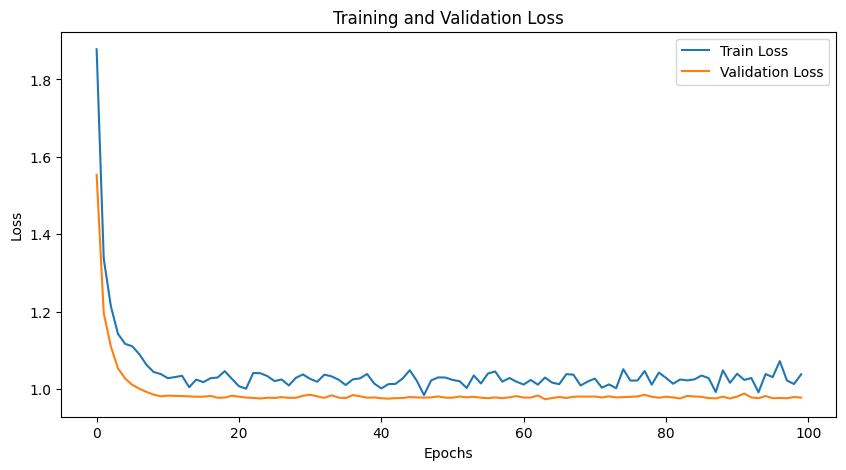

In [16]:
# 학습 및 검증 손실 시각화
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


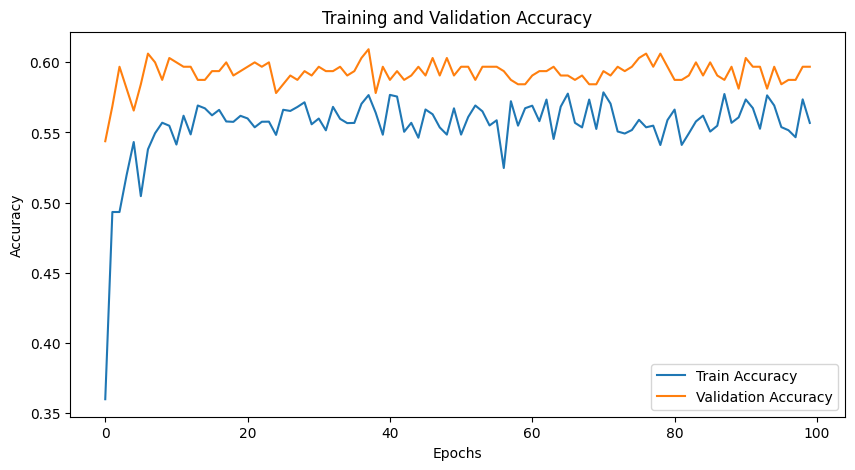

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), train_accuracies, label='Train Accuracy')
plt.plot(range(epochs), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()


In [18]:
# 저장된 모델 불러오기
load_model = MyCustomModel()
load_model.load_state_dict(torch.load("best_model.pth"))

<All keys matched successfully>

In [19]:
load_model.to(device)
load_model.eval()
test_loss = 0.0
test_accuracy = 0.0
with torch.no_grad():
    for data, labels in test_loader:
        data, labels = data.to(device), labels.to(device)
        outputs = load_model(data)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        test_accuracy += calcuate_acc(outputs, labels)

test_loss /= len(test_loader)
test_accuracy /= len(test_loader)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2%}')

# 개별 데이터 포인트 예측
sample = torch.tensor(X_test[0], dtype=torch.float32).to(device).unsqueeze(0)
model.eval()
with torch.no_grad():
    output = load_model(sample)
    _, predicted_class = torch.max(output.data, 1)
    print(f'샘플의 실제 품질: {y_test[0]}, 예측한 품질: {predicted_class.item()}')


Test Loss: 0.9152, Test Accuracy: 62.19%
샘플의 실제 품질: 6, 예측한 품질: 6
